# Sử dụng mô hình LR dự báo nhiệt độ trung bình London

In [47]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

In [48]:
# === BƯỚC 1: Đọc dữ liệu ===
df = pd.read_csv("london_weather.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0 1979-01-01          2.0       7.0              52.0       2.3       -4.1   
1 1979-01-02          6.0       1.7              27.0       1.6       -2.6   
2 1979-01-03          5.0       0.0              13.0       1.3       -2.8   
3 1979-01-04          8.0       0.0              13.0      -0.3       -2.6   
4 1979-01-05          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0

In [49]:
# Thông tin dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15341 non-null  datetime64[ns]
 1   cloud_cover       15322 non-null  float64       
 2   sunshine          15341 non-null  float64       
 3   global_radiation  15322 non-null  float64       
 4   max_temp          15335 non-null  float64       
 5   mean_temp         15305 non-null  float64       
 6   min_temp          15339 non-null  float64       
 7   precipitation     15335 non-null  float64       
 8   pressure          15337 non-null  float64       
 9   snow_depth        13900 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.2 MB


In [50]:
# Thống kê dữ liệu mẫu
df.describe()

date   cloud_cover      sunshine  global_radiation  \
count                15341  15322.000000  15341.000000      15322.000000   
mean   2000-01-01 00:00:00      5.268242      4.350238        118.756951   
min    1979-01-01 00:00:00      0.000000      0.000000          8.000000   
25%    1989-07-02 00:00:00      4.000000      0.500000         41.000000   
50%    2000-01-01 00:00:00      6.000000      3.500000         95.000000   
75%    2010-07-02 00:00:00      7.000000      7.200000        186.000000   
max    2020-12-31 00:00:00      9.000000     16.000000        402.000000   
std                    NaN      2.070072      4.028339         88.898272   

           max_temp     mean_temp      min_temp  precipitation       pressure  \
count  15335.000000  15305.000000  15339.000000   15335.000000   15337.000000   
mean      15.388777     11.475511      7.559867       1.668634  101536.605594   
min       -6.200000     -7.600000    -11.800000       0.000000   95960.000000   
25%       10.500000      7.000000      3.500000       0.000000  100920.000000   
50%       15.000000     11.400000      7.800000       0.000000  101620.000000   
75%       20.300000     16.000000     11.800000       1.600000  102240.000000   
max       37.900000     29.000000     22.300000      61.800000  104820.000000   
std        6.554754      5.729709      5.326756       3.738540    1049.722604   

         snow_depth  
count  13900.000000  
mean       0.037986  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       22.000000  
std        0.545633

In [51]:
# Thống kê dữ liệu thiếu
missing_data = df.isna().sum()
missing_data_percent = (missing_data / len(df)) * 100
statistic_missing_data = pd.DataFrame({
    "Missing Data Count": missing_data,
    "Missing Data Percent": missing_data_percent.round(2)
})
print("Thống kê dữ liệu thiếu: ")
statistic_missing_data

Thống kê dữ liệu thiếu: 


Missing Data Count  Missing Data Percent
date                               0                  0.00
cloud_cover                       19                  0.12
sunshine                           0                  0.00
global_radiation                  19                  0.12
max_temp                           6                  0.04
mean_temp                         36                  0.23
min_temp                           2                  0.01
precipitation                      6                  0.04
pressure                           4                  0.03
snow_depth                      1441                  9.39

In [52]:
# === BƯỚC 2: Điền giá trị thiếu bằng trung bình ===
cols_to_fill = [
    "cloud_cover", "global_radiation", "max_temp", "mean_temp", "min_temp",
    "precipitation", "snow_depth", "pressure"
]
for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].mean())

In [53]:
data_handle = df.isna().sum()
data_handle_percent = (data_handle / len(df)) * 100
statistic_data_handle = pd.DataFrame({
    "Missing Data Count": data_handle,
    "Missing Data Percent": data_handle_percent
})
print("Dữ liệu thiếu sau xử lý:")
statistic_data_handle


Dữ liệu thiếu sau xử lý:


Missing Data Count  Missing Data Percent
date                               0                   0.0
cloud_cover                        0                   0.0
sunshine                           0                   0.0
global_radiation                   0                   0.0
max_temp                           0                   0.0
mean_temp                          0                   0.0
min_temp                           0                   0.0
precipitation                      0                   0.0
pressure                           0                   0.0
snow_depth                         0                   0.0

In [54]:
# === BƯỚC 3: Tạo độ trễ cho mean_temp ===
df['mean_temp_lag1'] = df['mean_temp'].shift(1)
df['mean_temp_lag2'] = df['mean_temp'].shift(2)
df['mean_temp_lag3'] = df['mean_temp'].shift(3)

In [55]:
# === BƯỚC 4: Loại bỏ dòng thiếu sau khi tạo độ trễ ===
df.dropna(inplace=True)

In [56]:
# === BƯỚC 5: Xác định X và y ===
features = ['mean_temp_lag1', 'mean_temp_lag2', 'mean_temp_lag3',
            'cloud_cover', 'global_radiation', 'max_temp', 'min_temp',
            'precipitation', 'pressure', 'snow_depth']
X = df[features]
y = df['mean_temp']

In [57]:
# === BƯỚC 6: Chia train/test theo thời gian (80/20) ===
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [58]:
# === BƯỚC 7: Huấn luyện mô hình ===
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [59]:
# === BƯỚC 8: Dự đoán ===
y_pred = model.predict(X_test)

In [62]:
# === BƯỚC 9: Đánh giá ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2_square = r2_score(y_test, y_pred)
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3%}")
print(f"R2 Score: {r2_square:.3f}")

MAE: 0.696
RMSE: 0.932
MAPE: 9.672%
R2 Score: 0.973


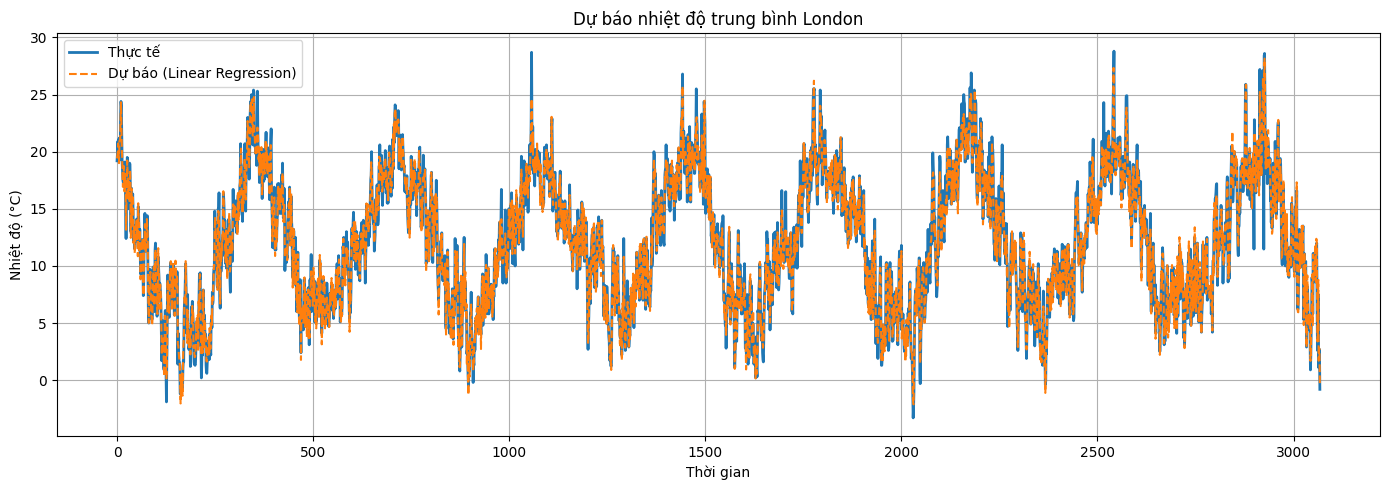

In [61]:
# === BƯỚC 10: Vẽ biểu đồ so sánh thực tế và dự báo ===
plt.figure(figsize=(14,5))
plt.plot(y_test.values, label='Thực tế', linewidth=2)
plt.plot(y_pred, label='Dự báo (Linear Regression)', linestyle='--')
plt.title('Dự báo nhiệt độ trung bình London')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()